In [1]:
import copy
import numpy as np

import galprime as gp

import photutils 

from matplotlib import pyplot as plt

from scipy.optimize import leastsq

40


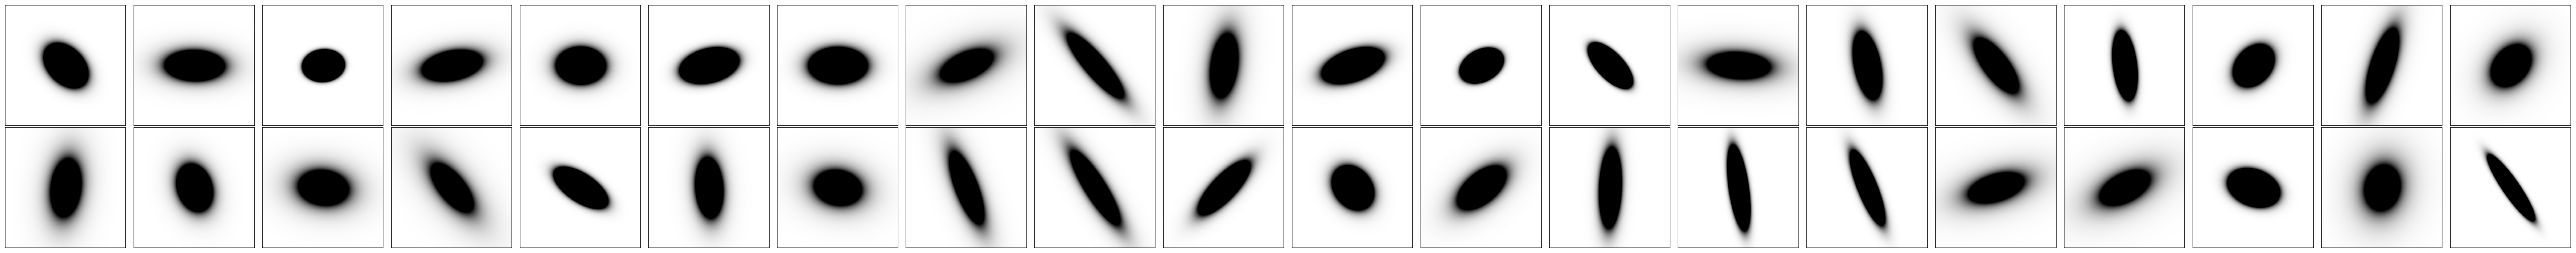

In [2]:
models = gp.gen_sersic_models(n_models=40, width=151)

gp.plotting.show_cutouts(models, ncols=20, nrows=2)

In [3]:
class Isophote:
    def __init__(self, x0=None, y0=None, sma=None, eps=None, pa=None):
        self.x0 = x0
        self.y0 = y0
        self.sma = sma
        self.eps = eps
        self.pa = pa

        self.stop_code = 0          # 0 = No errors but fit not good enough yet, 1 = good fit, 2 = error
        self.niters = 0

    def get_params(self):
        return np.array([self.x0, self.y0, self.sma, self.eps, self.pa])
    

    def __repr__(self) -> str:
        return f"Isophote(x0={self.x0}, y0={self.y0}, sma={self.sma}, eps={self.eps}, pa={self.pa}), stop_code={self.stop_code}"
    
    def copy(self):
        return Isophote(x0=self.x0, y0=self.y0, sma=self.sma, eps=self.eps, pa=self.pa)
    

iso = Isophote(x0=75, y0=75, sma=10, eps=0.5, pa=0)
print(iso)

Isophote(x0=75, y0=75, sma=10, eps=0.5, pa=0), stop_code=0


In [31]:
class IsophoteFitter:
    def __init__(self, data, init_guess=None, **kwargs):
        self.data = data
        self.init_guess = init_guess

        self.isophotes = []

        self.fitters = [gp.AdustPmin, gp.AdustPmaj, gp.AdjustPA, gp.AdjustEllipticity]


        self.fix_center = kwargs.get('fix_center', False)
        self.fix_eps = kwargs.get('fix_eps', False)
        self.fix_pa = kwargs.get('fix_pa', False)

        self.harmonic_mask = np.array([self.fix_center, self.fix_center, self.fix_eps, self.fix_pa])

        self.min_samples = 10

        self.err_frac = 0.04

        self.EPS_PAD = 0.05


    def fit_image(self, r_max=30, r_min=4, linear=True, step=0.1):
        init_fit = self.fit_isophote(self.init_guess)
        self.isophotes.append(init_fit)

        r_init = self.init_guess.sma
        
        # Go outwards
        current_isophote = copy.deepcopy(init_fit)
        current_isophote.stop_code = 0
        while r_init < r_max:
            
            if linear:
                r_init += step
            else:
                r_init *= (1 + step)

            current_isophote.sma = r_init
            current_isophote = self.fit_isophote(current_isophote)

            self.isophotes.append(current_isophote)

        # Go inwards
        r_init = self.init_guess.sma
        current_isophote = copy.deepcopy(init_fit)
        current_isophote.stop_code = 0
        while r_init > r_min:
            
            if linear:
                r_init -= step
            else:
                r_init /= (1 + step)
            current_isophote.sma = r_init
            current_isophote = self.fit_isophote(current_isophote)

            self.isophotes.append(current_isophote)



    def fit_isophote(self, guess, min_iters=10, max_iters=100):
        
        E = gp.eccentric_anomaly(np.linspace(0, 2*np.pi, np.max([10, int(2 * np.pi * guess.sma)])),
                              ellip=self.init_guess.eps)
        try:
            new_isophote = self.fit_single(guess, E)
        except TypeError as e:
            print("Error fitting isophote: ", e, guess)

        iteration = 0
        while iteration < max_iters:
            try:
                new_isophote = self.fit_single(new_isophote, E)
            except TypeError as e:
                print("Error fitting isophote: ", e, guess)
                
            iteration += 1

            if new_isophote.stop_code == 1 and iteration >= min_iters:
                break
        
        new_isophote.niters = iteration
        
        # Now good, fit upper harmonics
        E_masked, samp = gp.sample(self.data, new_isophote, E)
        try:
            upper_harmonics = gp.fit_higher_harmonics(E_masked, samp)
        except TypeError as e:
            print("Error fitting upper harmonics: ", e, new_isophote)
            return new_isophote
        
        return new_isophote


    def fit_single(self, guess, E):
        """ Adjust a single harmonic of an isophote ( 1 iteration of the isophote fitting process).

        Args:
            guess (_type_): _description_
            E (_type_): _description_

        Returns:
            _type_: _description_
        """
        E_masked, samp = gp.sample(self.data, guess, E)
        grad = gp.gradient(self.data, guess, E_masked)

        i0, a1, a2, b1, b2 = gp.fit_lower_harmonics(E_masked, samp)
        mod = gp.lower_harmonic_function(E_masked, [i0, a1, b1, a2, b2])
        resid = samp - mod

        lower_harmonics = np.array([a1, a2, b1, b2])
        lower_harmonics[self.harmonic_mask] = 0

        largest_harmonic = np.argmax(np.abs(lower_harmonics))

        new_isophote = self.fitters[largest_harmonic](guess, lower_harmonics[largest_harmonic], grad)

        good_fit = np.abs(lower_harmonics[largest_harmonic]) < self.err_frac * np.nanstd(resid)
        if good_fit:
            new_isophote.stop_code = 1

        new_isophote = self.check_isophote(new_isophote)
        return new_isophote
    

    def check_isophote(self, iso):
        if iso.eps < self.EPS_PAD:
            iso.eps = self.EPS_PAD
        elif iso.eps > 1 - self.EPS_PAD:
            iso.eps = 1 - self.EPS_PAD
        
        return iso


cutout = models.cutouts[0]
test = IsophoteFitter(cutout, 
                      init_guess=Isophote(x0=cutout.shape[0] / 2, y0=cutout.shape[1] / 2, sma=15, eps=0.4, pa=1.2),
                      fix_center=True)

#%timeit test.fit_image()
test.fit_image(linear=False, r_min=4)


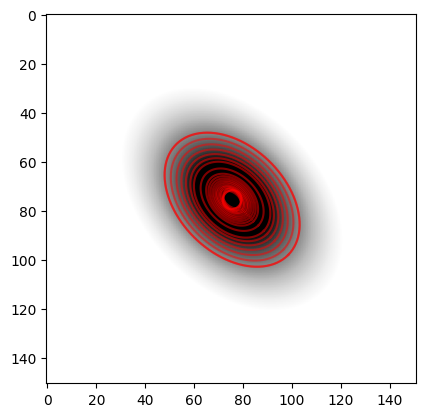

In [32]:
phis = np.linspace(0, 2*np.pi, 100)

plt.imshow(np.log10(cutout), cmap="Greys", vmin=-5, vmax=-2)
for iso in test.isophotes:
    coords_x, coords_y = gp.ellipse_coords(iso, phis, asint=False)

    plt.plot(coords_x, coords_y, 'r', alpha=0.5)

